In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AveragePooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50, ResNet152
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [ ]:
labels = pd.read_csv('/content/drive/My Drive/agePrediction/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
eva_labels = pd.read_csv('/content/drive/My Drive/agePrediction/test_labels.csv')
eva_labels.head()

,file_name,real_age
0,006000.jpg,57
1,006001.jpg,57
2,006002.jpg,52
3,006003.jpg,22
4,006005.jpg,37


Text(0.5, 1.0, 'Distribution of Age')

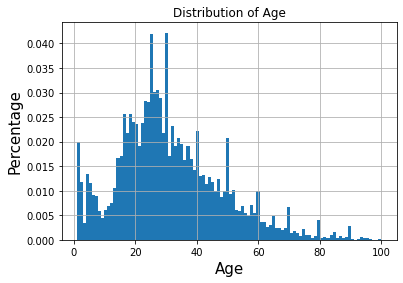

In [ ]:
labels.hist(bins=100,density=True)
plt.xlabel('Age', fontsize=15)
plt.ylabel('Percentage', fontsize=15)
plt.title('Distribution of Age')

In [ ]:
train_data = ImageDataGenerator(validation_split=0.25, rescale=1./255, horizontal_flip=True)
train_gen_flow = train_data.flow_from_dataframe(
        dataframe=labels,
        directory='/content/drive/My Drive/agePrediction/training/',
        x_col='file_name',
        y_col='real_age',
        target_size=(200, 200),
        batch_size=20,
        class_mode='raw',
        seed=14,
        subset = 'training'
)

Found 4500 validated image filenames.


In [ ]:
test_data = ImageDataGenerator(validation_split=0.25, rescale=1./255)
test_gen_flow = test_data.flow_from_dataframe(
        dataframe=labels,
        directory='/content/drive/My Drive/agePrediction/training/',
        x_col='file_name',
        y_col='real_age',
        target_size=(200, 200),
        batch_size=20,
        class_mode='raw',
        seed=14,
        subset='validation')

Found 1499 validated image filenames.


In [ ]:
eva_data = ImageDataGenerator(rescale=1./255)
eva_gen_flow = eva_data.flow_from_dataframe(
        dataframe=eva_labels,
        directory='/content/drive/My Drive/agePrediction/testing/',
        x_col='file_name',
        y_col='real_age',
        target_size=(200, 200),
        #batch_size=20,
        class_mode='raw',
        seed=14
)

Found 1592 validated image filenames.


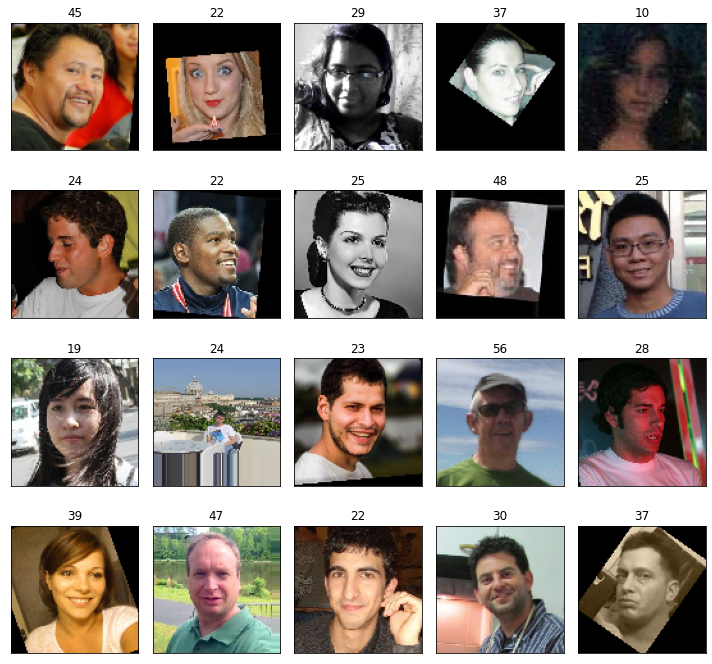

In [ ]:
images, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(20):
    fig.add_subplot(4, 5, i+1)
    plt.imshow(images[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [ ]:
#create ResNet50 model architecture
optimizer= Adam(lr=0.0001) 
backbone = ResNet50(input_shape=(200,200,3), weights='imagenet', include_top=False)
model = Sequential()
model.add(backbone)
model.add(Dropout(0.1))
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='relu'))
model.compile(loss="mean_squared_error",optimizer=optimizer, metrics=["mae"])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 2048)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
None


In [ ]:
#create ResNet152 model architecture
optimizer= Adam(lr=0.0001) 
backbone = ResNet152(input_shape=(200,200,3), weights='imagenet', include_top=False)
model2 = Sequential()
model2.add(backbone)
model2.add(Dropout(0.1))
model2.add(GlobalAveragePooling2D())
model2.add(Dense(1, activation='relu'))
model2.compile(loss="mean_squared_error",optimizer=optimizer, metrics=["mae"])
print(model2.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 7, 7, 2048)        58370944  
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 2048)        0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2049      
Total params: 58,372,993
Trainable params: 58,221,569
Non-trainable params: 151,424
_________________________________________________________________
None


In [ ]:
my_callbacks = [EarlyStopping(patience=2),ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),]

def train_model(model, train_data, test_data,batch_size=None,epochs=20, steps_per_epoch =None, validation_steps=None):
    model.fit(train_data,
          validation_data=test_data,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          verbose=1, epochs=epochs,callbacks= my_callbacks)
    return model

In [ ]:
trained_model2 = train_model(model2, train_gen_flow, test_gen_flow)

Epoch 1/20
225/225 [==============================] - 323s 1s/step - loss: 202.6990 - mae: 10.2920 - val_loss: 839.5548 - val_mae: 23.9278
Epoch 2/20
225/225 [==============================] - 300s 1s/step - loss: 90.6882 - mae: 7.2187 - val_loss: 355.6394 - val_mae: 14.2406
Epoch 3/20
225/225 [==============================] - 300s 1s/step - loss: 61.1925 - mae: 5.9343 - val_loss: 125.7616 - val_mae: 8.5718
Epoch 4/20
225/225 [==============================] - 300s 1s/step - loss: 44.1689 - mae: 5.0147 - val_loss: 108.4312 - val_mae: 7.6959
Epoch 5/20
225/225 [==============================] - 301s 1s/step - loss: 34.7063 - mae: 4.4899 - val_loss: 78.7430 - val_mae: 6.8205
Epoch 6/20
225/225 [==============================] - 300s 1s/step - loss: 29.4231 - mae: 4.1515 - val_loss: 69.3390 - val_mae: 6.3265
Epoch 7/20
225/225 [==============================] - 300s 1s/step - loss: 24.5821 - mae: 3.8201 - val_loss: 63.8346 - val_mae: 6.0403
Epoch 8/20
225/225 [===========================

In [ ]:
trained_model = train_model(model, train_gen_flow, test_gen_flow)

Epoch 1/20
225/225 [==============================] - 127s 538ms/step - loss: 223.0823 - mae: 10.7463 - val_loss: 652.1039 - val_mae: 20.5025
Epoch 2/20
225/225 [==============================] - 120s 533ms/step - loss: 80.1775 - mae: 6.8599 - val_loss: 578.2594 - val_mae: 18.8583
Epoch 3/20
225/225 [==============================] - 120s 533ms/step - loss: 59.7749 - mae: 5.8750 - val_loss: 180.1069 - val_mae: 10.1250
Epoch 4/20
225/225 [==============================] - 120s 533ms/step - loss: 41.5336 - mae: 4.9414 - val_loss: 131.5140 - val_mae: 8.4286
Epoch 5/20
225/225 [==============================] - 120s 532ms/step - loss: 34.0089 - mae: 4.4925 - val_loss: 71.6691 - val_mae: 6.4531
Epoch 6/20
225/225 [==============================] - 120s 533ms/step - loss: 27.4779 - mae: 4.0541 - val_loss: 67.1836 - val_mae: 6.0253
Epoch 7/20
225/225 [==============================] - 120s 534ms/step - loss: 25.3596 - mae: 3.8594 - val_loss: 98.2697 - val_mae: 7.3518
Epoch 8/20
225/225 [=====

In [ ]:
loss = trained_model.history.history['loss']
mae = trained_model.history.history['mae']
val_loss = trained_model.history.history['val_loss']
val_mae = trained_model.history.history['val_mae']

Text(0.5, 1.0, 'Training and Validation Loss')

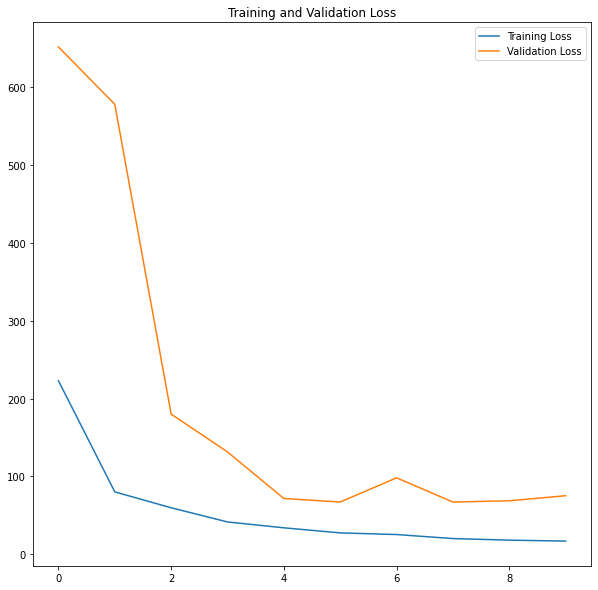

In [ ]:
epochs_range = range(10)

plt.figure(figsize=(10, 10))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='top right')
plt.title('Training and Validation Loss')

Text(0.5, 1.0, 'Training and Validation MAE')

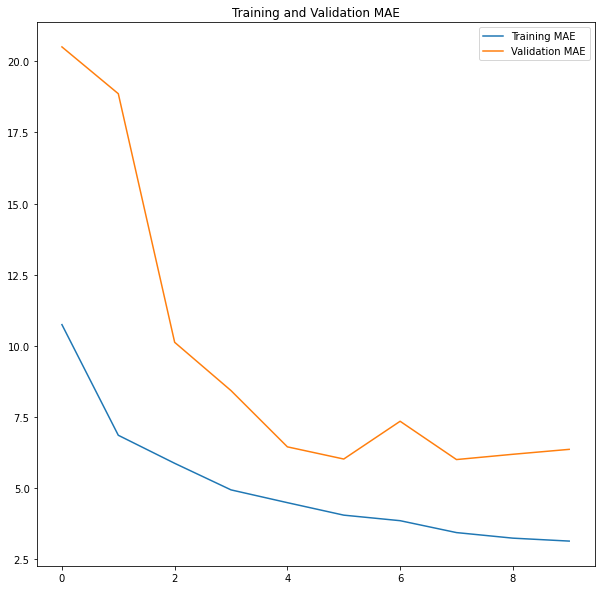

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

In [ ]:
loss2 = trained_model2.history.history['loss']
mae2 = trained_model2.history.history['mae']
val_loss2 = trained_model2.history.history['val_loss']
val_mae2 = trained_model2.history.history['val_mae']

Text(0.5, 1.0, 'Training and Validation Loss')

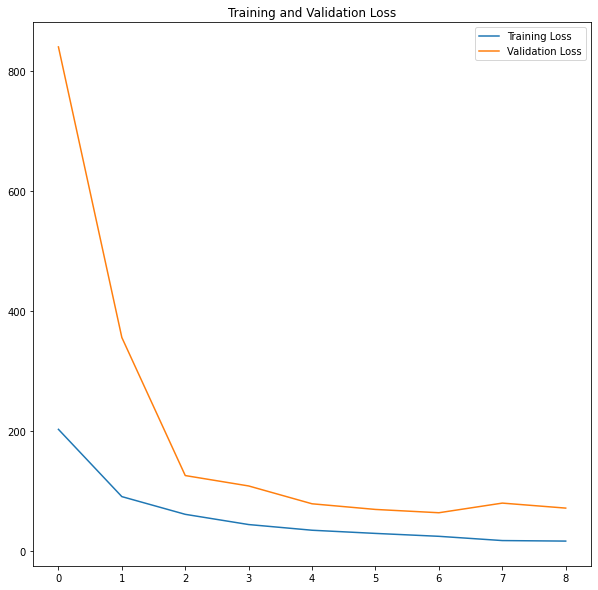

In [ ]:
epochs_range = range(9)

plt.figure(figsize=(10, 10))
plt.plot(epochs_range, loss2, label='Training Loss')
plt.plot(epochs_range, val_loss2, label='Validation Loss')
plt.legend(loc='top right')
plt.title('Training and Validation Loss')

Text(0.5, 1.0, 'Training and Validation MAE')

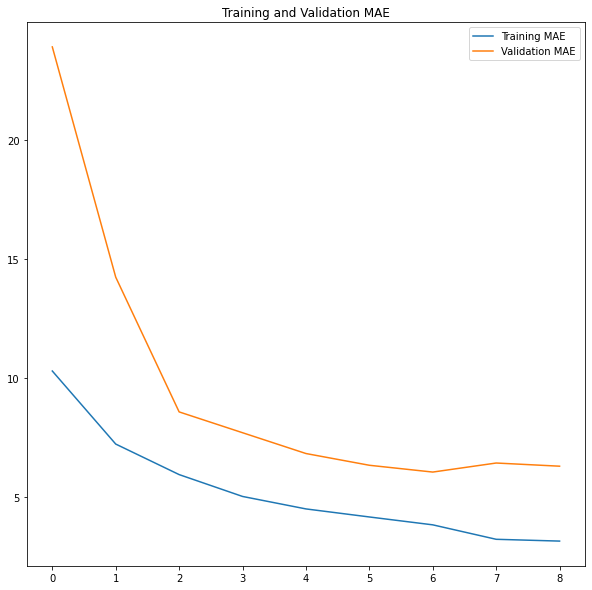

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(epochs_range, mae2, label='Training MAE')
plt.plot(epochs_range, val_mae2, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

### Measure of Model Performance
Since we are doing a regression problem, unlike classification, accuracy, precision, and recall are hard to illustrate. We rather show how close is the prediction against real ages by Mean Absolute Error and Mean Square Error. The trained model we have give us **MAE of 8** and **MSE of 129** on testing image dataset.

In [ ]:
model_result = trained_model.evaluate(eva_gen_flow, verbose=0)
model_result

[107.91544342041016, 7.858157157897949]

In [ ]:
print('Prediction MAE on testing dataset is:', model_result[1], 'MSE is:', model_result[0])

Prediction MAE on testing dataset is: 7.858157157897949 MSE is: 107.91544342041016


In [ ]:
#read in test sample image labels
test_sample_labels = pd.read_csv('/content/drive/My Drive/agePrediction/test_sample_labels.csv')
test_sample_labels.head()

,file_name,real_age
0,006009.jpg,19
1,006010.jpg,20


In [ ]:
#load final evaluation dataset
test_sample_data = ImageDataGenerator(rescale=1./255)
sample_gen_flow = test_sample_data.flow_from_dataframe(
        dataframe=test_sample_labels,
        directory='/content/drive/My Drive/agePrediction/testing_samples/',
        x_col='file_name',
        y_col='real_age',
        target_size=(200, 200),
        batch_size=20,
        shuffle = False,
        class_mode='raw',
        seed=1434
)

Found 2 validated image filenames.


In [ ]:
result = trained_model.predict(sample_gen_flow, verbose=0)

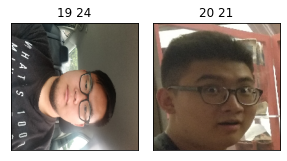

In [ ]:
images, target = next(sample_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(2):
    fig.add_subplot(4, 5, i+1)
    plt.imshow(images[i])
    plt.title(str(target[i])+" "+str(int(result[i])))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()